In [1]:
import os
import sys
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")
sys.path.insert(0, f"{root}/src/python/python/loaders")

import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb', 'cuda_ad_rgb')

from mitsuba import ScalarTransform4f as T
from gaussnewton import conjugate_gradient, AlbedoScene

sensor_count = 5
sensor_dict = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 64 * sensor_count, 'height': 64,
        'filter': {'type': 'box'},
        'pixel_format': 'rgba'
    }
}

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = mi.ScalarTransform4f.rotate([0, 1, 0], angle)
    sensor_to_world = mi.ScalarTransform4f.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensor_dict[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        }
sensor = mi.load_dict(sensor_dict)
    
def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off');

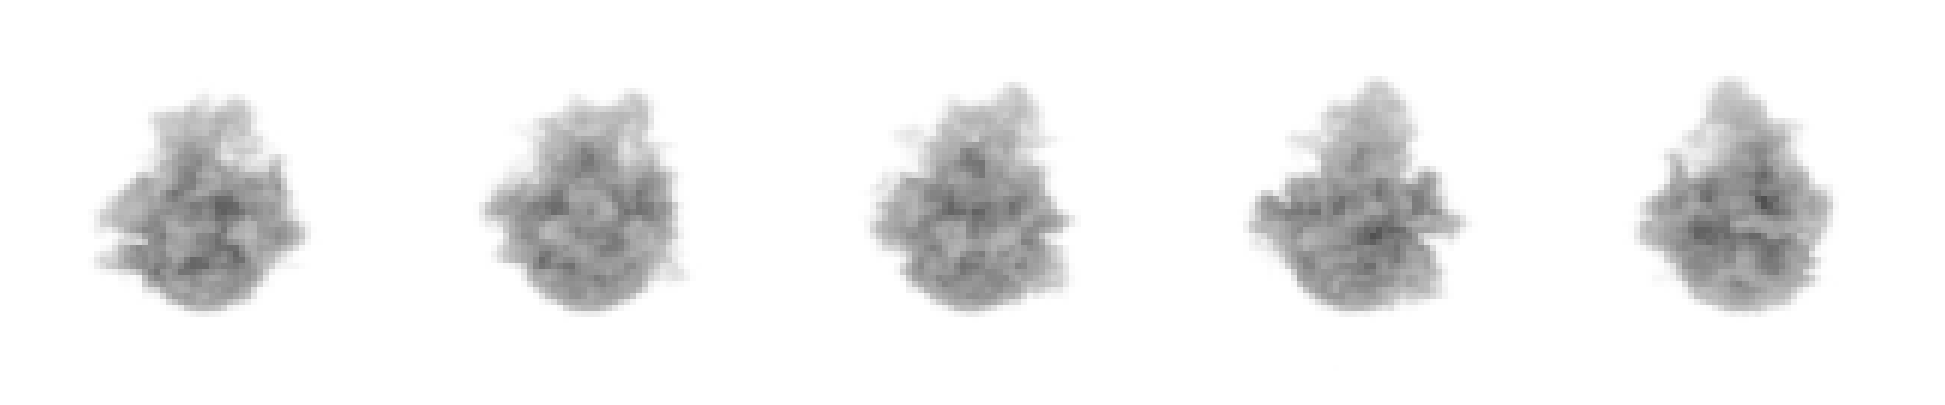

In [2]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prbvolpath'},
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': './tutorials/scenes/volume.vol',
                'to_world': mi.ScalarTransform4f.rotate([1, 0, 0], -90).scale(2).translate(-0.5)
            },
            'scale': 40
        }
    },
    'emitter': {'type': 'constant'}
}

scene_ref = mi.load_dict(scene_dict)

# Number of samples per pixel for reference images
ref_spp = 512

ref_images = mi.render(scene_ref, sensor=sensor, spp=ref_spp)
plot_batch_output(ref_images)

In [ ]:
v_res = 16

# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': mi.ScalarTransform4f.translate(-1).scale(2.0)
        },
        'scale': 40.0,
    },
    'bsdf': {'type': 'null'}
}

scene = mi.load_dict(scene_dict)

init_images = mi.render(scene, sensor=sensor, spp=ref_spp)
plot_batch_output(init_images)

In [ ]:
# params = mi.traverse(scene)

# #key = {'sigmat': params['sigmat']} #'object.interior_medium.sigma_t.data'
# keys = {'object.interior_medium.sigma_t.data'}
# experiment_idx = -1
# sc = AlbedoScene(scene, params,  keys, sensor, ref_images = ref_images, _EXP_IDX = experiment_idx)

# iteration_count = 40
# spp = 8
# loss = sc.eval_func()
# for it in range(iteration_count):
    
#     # Compute the Gauss-Newton descent direction
#     descent_dir = conjugate_gradient(sc.values(), loss, sc)

#     # Optimizer: take a Gauss Newton descent step
#     sc.step(descent_dir)

#     # Compute the loss using the current parameter values
#     loss = sc.eval_func()

#     # Clamp the optimized density values. Since we used the `scale` parameter
#     # when instantiating the volume, we are in fact optimizing extinction
#     # in a range from [1e-6 * scale, scale].
#     # opt[key] = dr.clamp(opt[key], 1e-6, 1.0)

#     # Propagate changes to the scene
#     # params.update(opt)
#     print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

In [ ]:

params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02)
opt[key] = params[key]
params.update(opt);

iteration_count = 40
spp = 4

for it in range(iteration_count):
    
    img = mi.render(scene, params, sensor=sensor, spp=spp, seed=it)

    # L2 loss function
    loss = dr.mean(dr.sqr(img - ref_images))

    # Backpropagate gradients
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Clamp the optimized density values. Since we used the `scale` parameter
    # when instantiating the volume, we are in fact optimizing extinction
    # in a range from [1e-6 * scale, scale].
    opt[key] = dr.clamp(opt[key], 1e-6, 1.0)

    # Propagate changes to the scene
    params.update(opt)
    print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

In [ ]:
intermediate_images = mi.render(scene, sensor=sensor, spp=ref_spp)
plot_batch_output(intermediate_images)